# Курс орнитологии

1. Реализуйте модель для извлечения признаков из голоса птиц. За основу можно брать:
   - преобразование в аудиофичи (например как mfcc в лекции. Конкретно это преобразование использовать нельзя)
   - обученные поверх аудиофич ML модели
  
1. С помощью модели и одного из предложенных датасетов создайте эмбеддинги пения птиц. Создайте эмбеддинги нескольких записей каждого вида птиц. Визуализируйте эмбеддинги. Для визуализации рекомендуется использовать подмножество видов птиц

1. Аргументируйте почему ваша модель хорошо извлекает признаки из аудио. 
    - Покажите кластеризацию эмбеддингов по видам

1. С помощью эмбеддингов найдите похожие по звучанию виды птиц. Выведите примеры их пения в ноутбуке.



Датасеты:
1. [Датасет](https://www.kaggle.com/vinayshanbhag/bird-song-data-set) американских птиц
1. Почищенный от фонового шума BirdCall [датасет](https://www.kaggle.com/luisblanche/birdcall-singing-3)
1. [Датасет](https://www.kaggle.com/luisblanche/birdcall-singing-0) BirdCall часть 1

In [1]:
import librosa
import librosa.display as librosa_display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch
import pandas as pd

In [2]:
meta = pd.read_csv('data/raw/bird_songs_metadata.csv')
meta

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-8.wav
5418,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-10.wav
5419,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-14.wav
5420,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-15.wav


In [3]:
from tqdm.notebook import tqdm

filter_specs = set()
filter_specs.add('bewickii')
filter_specs.add('polyglottos')
filter_specs.add('migratorius')
# meta_filt = meta[meta.species.isin(filter_specs)].sample(1000)
meta_filt = meta
meta_filt

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-8.wav
5418,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-10.wav
5419,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-14.wav
5420,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-15.wav


In [4]:
from spafe.features.lfcc import lfcc

features = []
y = []
specs = set()
for i in tqdm(range(len(meta_filt))):
    specs.add(meta_filt.iloc[i].species)
    wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)
    wav = librosa.resample(wav, sr, 16000)
    features.append(lfcc(wav, 16000))
    y.append(meta_filt.iloc[i].species)
specs

  0%|          | 0/5422 [00:00<?, ?it/s]

{'bewickii', 'cardinalis', 'melodia', 'migratorius', 'polyglottos'}

In [21]:
X = []
for f in features:
    f0 = torch.flatten(torch.Tensor(f).mean(dim=1)[:32])
    f1 = torch.flatten(torch.Tensor(librosa.feature.delta(f)).mean(dim=1)[:32])
    X.append(torch.cat([f0, f1]))

In [22]:
X[0].shape

torch.Size([64])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [8]:
"""
from transformers import Wav2Vec2Model
from transformers import Wav2Vec2Config
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
"""

'\nfrom transformers import Wav2Vec2Model\nfrom transformers import Wav2Vec2Config\nfrom transformers import Wav2Vec2Processor\nfrom transformers import Wav2Vec2FeatureExtractor\n\nprocessor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")\nmodel = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)\n'

In [9]:
"""
import gc

model_outputs = []
XX = []
yy = []
specs = set()
with torch.no_grad():
    for i in tqdm(range(len(meta_filt))):
        specs.add(meta_filt.iloc[i].species)
        wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)
        wav = librosa.resample(wav, sr, 16000)
        input_values = processor(wav, return_tensors='pt', sampling_rate=16000).input_values.to(device)
        output = model.forward(input_values).last_hidden_state[0].to('cpu')
        model_outputs.append(output)
        XX.append(output.mean(dim=0))
        yy.append(meta_filt.iloc[i].species)
        if i % 25 == 0:
            gc.collect()
specs
"""

"\nimport gc\n\nmodel_outputs = []\nXX = []\nyy = []\nspecs = set()\nwith torch.no_grad():\n    for i in tqdm(range(len(meta_filt))):\n        specs.add(meta_filt.iloc[i].species)\n        wav, sr = librosa.load('data/raw/wavfiles/' + meta_filt.iloc[i].filename)\n        wav = librosa.resample(wav, sr, 16000)\n        input_values = processor(wav, return_tensors='pt', sampling_rate=16000).input_values.to(device)\n        output = model.forward(input_values).last_hidden_state[0].to('cpu')\n        model_outputs.append(output)\n        XX.append(output.mean(dim=0))\n        yy.append(meta_filt.iloc[i].species)\n        if i % 25 == 0:\n            gc.collect()\nspecs\n"

In [23]:
import umap

embs = umap.UMAP().fit_transform(torch.stack(X))

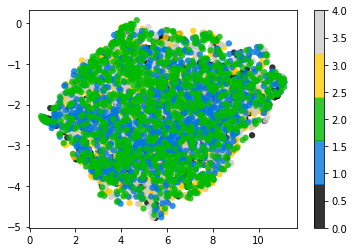

In [24]:
list_specs = list(specs)
plt.scatter(embs[:, 0], embs[:, 1],
            edgecolor='none', alpha=0.8, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(list_specs)),
            c=[list_specs.index(s) for s in y] )
plt.colorbar()
plt.show()

In [17]:
from sklearn.cluster import KMeans, DBSCAN
clusters = KMeans(n_clusters=len(specs), random_state=0).fit(torch.stack(X))

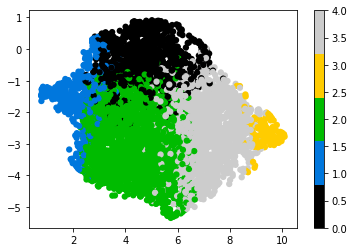

In [18]:
plt.scatter(embs[:, 0], embs[:, 1],
            edgecolor='none', alpha=1, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', len(list_specs)),
            c=clusters.labels_)
plt.colorbar()
plt.show()

In [ ]:
print(list_specs[4])
print(list_specs[0])
print(list_specs[3])

In [ ]:
import numpy.linalg

bird1 = -1
for i in range(len(embs)):
    if embs[i][1] > 8.9:
        if yy[i] == list_specs[0]:
            bird1 = i

min_dist = np.inf
bird2 = -1
for i in range(len(embs)):
    dist = np.linalg.norm(embs[i] - embs[bird1])
    if yy[i] == list_specs[4] and dist < min_dist:
        min_dist = dist
        bird2 = i

max_dist = 0
bird3 = -1
for i in range(len(embs)):
    dist = np.linalg.norm(embs[i] - embs[bird1])
    if embs[i][0] > 4 and embs[i][1] > 6 and yy[i] == list_specs[3] and dist > max_dist and np.random.randint(0, 10) > 5:
        max_dist = dist
        bird3 = i

max_dist = 0
bird4 = -1
for i in range(len(embs)):
    dist = np.linalg.norm(embs[i] - embs[bird1])
    if embs[i][0] > 4 and embs[i][1] > 6 and yy[i] == list_specs[1] and dist > max_dist and np.random.randint(0, 10) > 5:
        max_dist = dist
        bird4 = i

print(bird1)
print(bird2)
print(bird3)
print(bird4)

In [ ]:
import IPython
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird1].filename)

In [ ]:
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird2].filename)

In [ ]:
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird3].filename)

In [ ]:
IPython.display.Audio("data/raw/wavfiles/" + meta_filt.iloc[bird4].filename)